# 시계열 분석 연구과제
## 문제 1


temperatures_seoul 데이터는 1937년 07월 01일부터 2023년 08월 06일까지 서울의 평균 기온을 조사한 자료의 일부이다.

[예시]
날짜         평균기온(℃)
1973-07-01   22.7
1973-07-02   23.8
1973-07-03   27.2
1973-07-04   25.2
1973-07-05   26.9

이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 분석하고
앞으로 1년간의 평균 기온을 시각화 하시오.

시각화 기간은 2023년 8월 6일을 기준으로 전후 1년간으로 한다.


### #01. 준비작업
#### 1. 라이브러리 가져오기

In [ ]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import dates  #X/Y 출이 시계열일때 출력 형식 설정
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd


# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# 데이터 정상성 확인을 위한 ADF 검정
from statsmodels.tsa.stattools import adfuller

# ACF, PACF 테스트
from statsmodels.tsa.stattools import acf, pacf

# ACF, PACF 시각화 기능
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



#### 2. 시각화 초기화

In [72]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 3. 데이터 가져오기

In [73]:
origin = load_data('temperatures_seoul')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/lab13_/temperatures_seoul.xlsx
[desc] 1973년 7월 1일부터 2023년 8월 6일까지 서울의 일평균 기온 데이터 (출처: 기상청)
[!] Cannot read metadata

==== 데이터 크기 확인 ====
데이터셋 크기: (18299, 2)
열 개수: 2
행 개수: 18299

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   날짜       18299 non-null  datetime64[ns]
 1   평균기온(℃)  18299 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 286.1 KB
None


In [74]:
origin.tail()

,날짜,평균기온(℃)
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3
18298,2023-08-06,29.8


### 데이터 월별로 묶기

In [75]:
df = origin.copy()

# 1️⃣ 날짜를 datetime으로
df['날짜'] = pd.to_datetime(df['날짜'])

# 2️⃣ 날짜를 인덱스로 (resample 필수 조건)
df = df.set_index('날짜')

# 3️⃣ 월별 평균 (PeriodIndex ❌, DatetimeIndex ⭕)
monthly_df = df.resample('MS').mean()

monthly_df.head()


,평균기온(℃)
날짜,
1973-07-01,26.816129
1973-08-01,25.883871
1973-09-01,20.323333
1973-10-01,13.038710
1973-11-01,4.723333


In [76]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 602 entries, 1973-07-01 to 2023-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   평균기온(℃)  602 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


### 데이터 정상성 확인

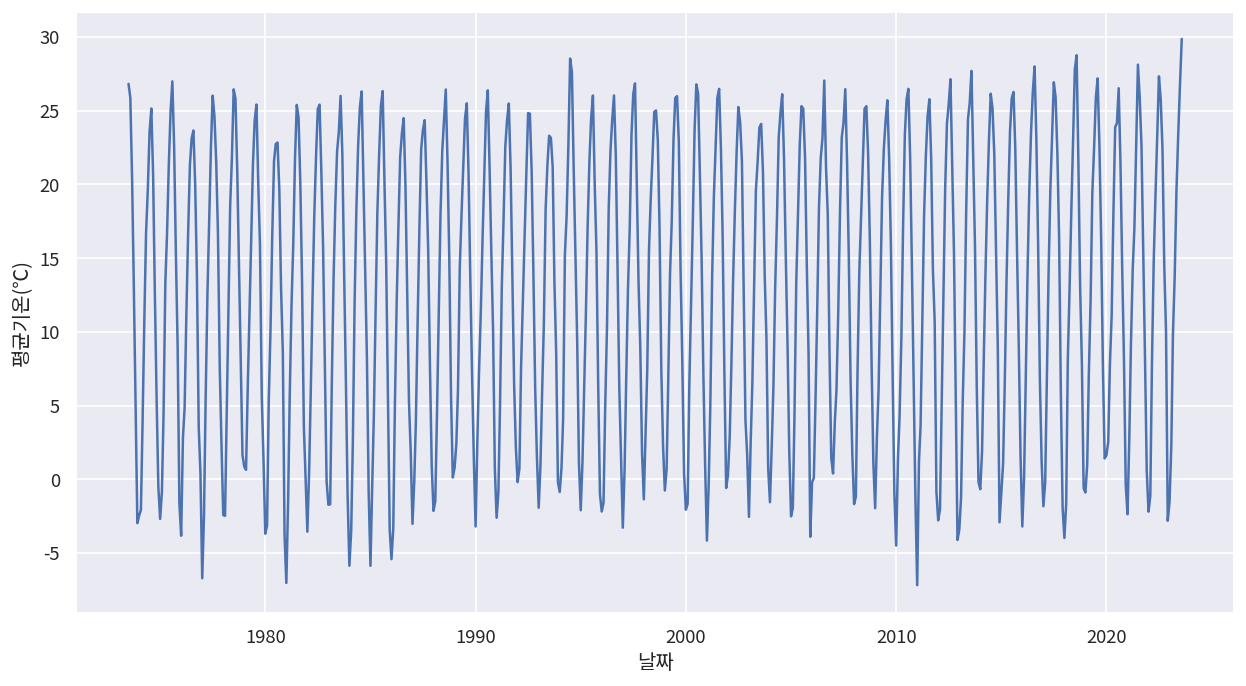

In [77]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.lineplot(
    data=monthly_df, x='날짜', y='평균기온(℃)',
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김


# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


In [78]:
ar = adfuller(origin['평균기온(℃)'])
ar

(np.float64(-13.650422403948678),
 np.float64(1.5897525859411133e-25),
 45,
 18253,
 {'1%': np.float64(-3.430708309311788),
  '5%': np.float64(-2.861698359287901),
  '10%': np.float64(-2.5668542904669103)},
 np.float64(79977.21628763777))

In [79]:
print('검정통계량 ADF statistic : %f'%ar[0])
print('유의수준 p-value : %f'%ar[1])
print('최적차수 (num of lags): %f' %ar[2])
print('관측치 개수 (num of observations) : %f' %ar[3])
print('기각값 (critical values)')
for key,value in ar[4].items():
  print('\t%s : %.3f' %(key,value))


print('데이터 정상성 여부 : ', ' 정상성 충족' if ar[1] <= 0.05 else '정상성 충족 안함')

검정통계량 ADF statistic : -13.650422
유의수준 p-value : 0.000000
최적차수 (num of lags): 45.000000
관측치 개수 (num of observations) : 18253.000000
기각값 (critical values)
	1% : -3.431
	5% : -2.862
	10% : -2.567
데이터 정상성 여부 :   정상성 충족


### 평균 이동법

In [80]:
df2 = monthly_df.copy()

df2['rolling3'] = df2['평균기온(℃)'].rolling(3).mean()
df2['rolling6'] = df2['평균기온(℃)'].rolling(6).mean()
df2['rolling9'] = df2['평균기온(℃)'].rolling(9).mean()



df2.head(10)

,평균기온(℃),rolling3,rolling6,rolling9
날짜,,,,
1973-07-01,26.816129,NaN,NaN,NaN
1973-08-01,25.883871,NaN,NaN,NaN
1973-09-01,20.323333,24.341111,NaN,NaN
1973-10-01,13.038710,19.748638,NaN,NaN
1973-11-01,4.723333,12.695125,NaN,NaN
1973-12-01,-2.977419,4.928208,14.634659,NaN
1974-01-01,-2.458065,-0.237384,9.755627,NaN
1974-02-01,-2.078571,-2.504685,5.095220,NaN
1974-03-01,3.687097,-0.283180,2.322514,9.662046


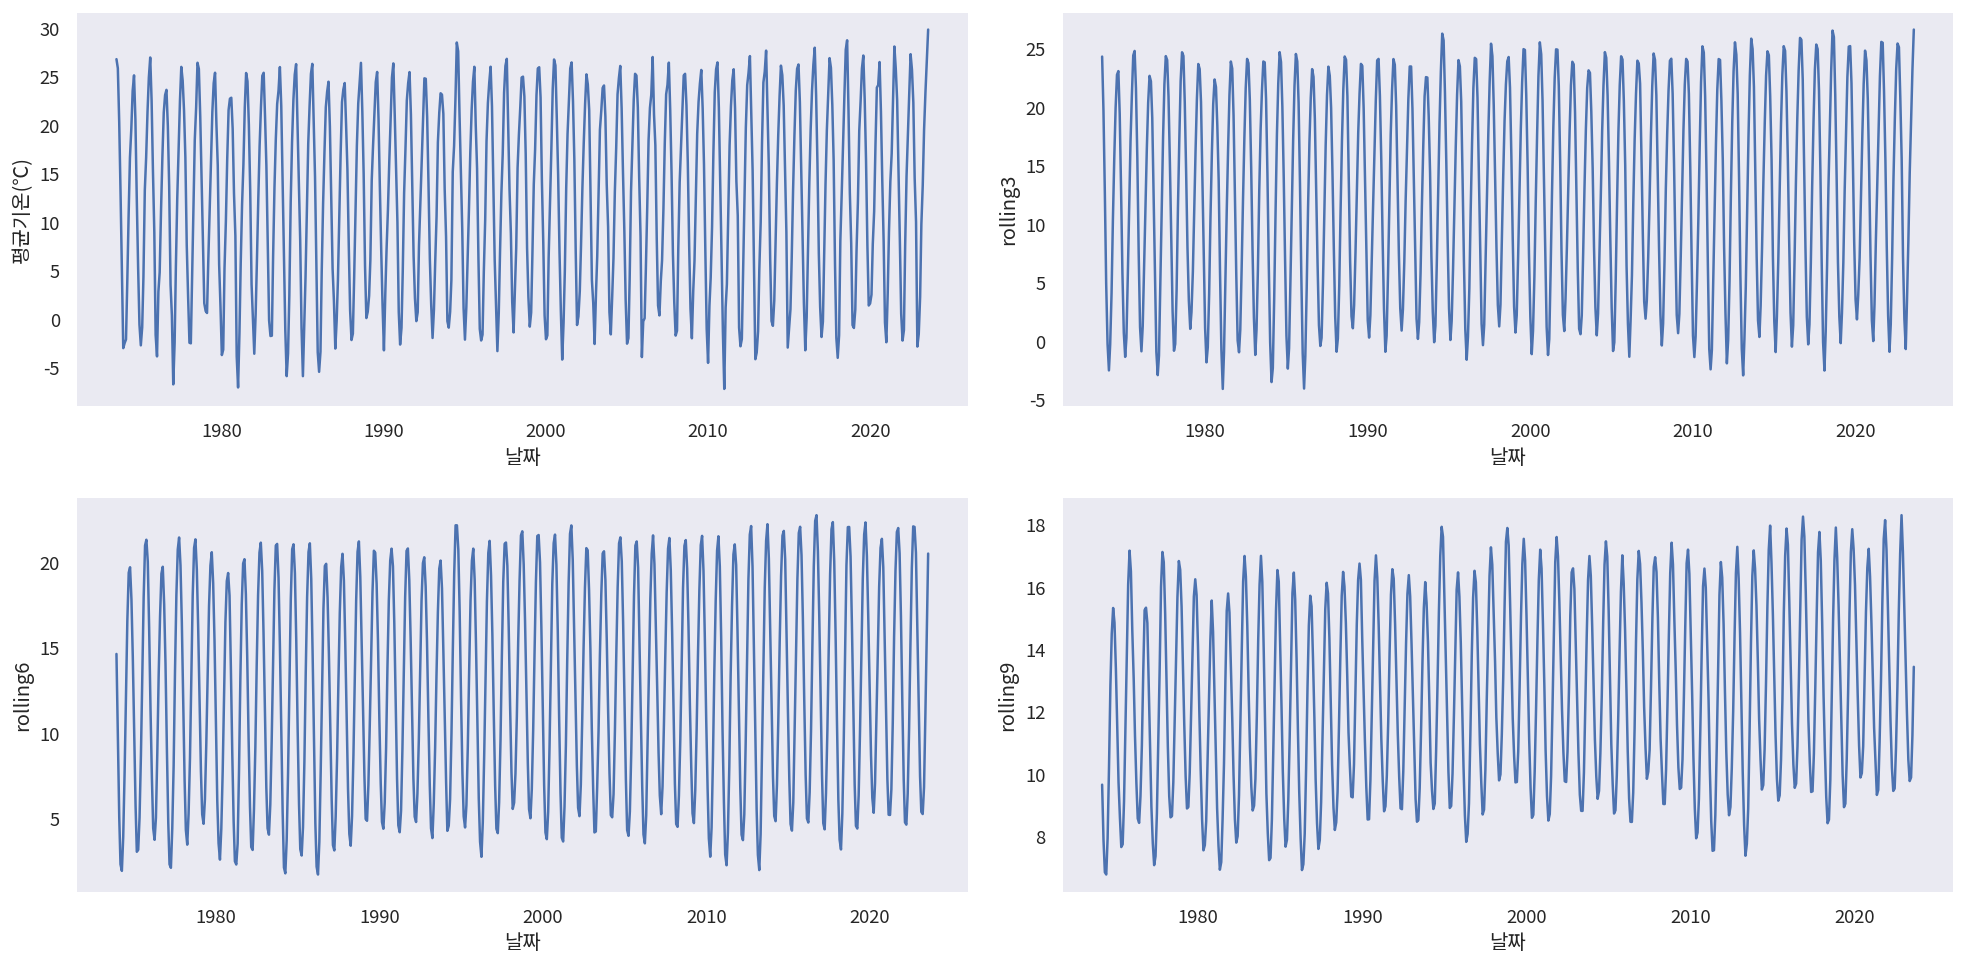

In [81]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2000              # 그래프 가로 크기
height_px = 1000              # 그래프 세로 크기
rows = 2                     # 그래프 행 수
cols = 2                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용

sb.lineplot(df2,x=df2.index,y='평균기온(℃)',ax=ax[0][0])
sb.lineplot(df2,x=df2.index,y='rolling3',ax=ax[0][1])
sb.lineplot(df2,x=df2.index,y='rolling6',ax=ax[1][0])
sb.lineplot(df2,x=df2.index,y='rolling9',ax=ax[1][1])  


# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


> 1년 주기의 주기 확인

- ACF 직접 계산하기! 

In [82]:
# 목적 : 과거 몇 시점(lag) 까지 현재에 영향을 주는지 자동으로 찾기

# 1. 차분된 시계열의 자기상관계수 (ACF) 계산 (lag 0 부터 시작)
acf_vals = acf(df2['평균기온(℃)'])  #이미 차분된 시계열 데이터를 acf()함수로 자기상관계수를 모두 계산한다 , 즉 지금 값이 과거의 나와 얼마나 닮았는지 숫자로 나타낸 것 


# 2. ACF 유의성 판단 기준 (근사적 95% 신뢰구간)
threshold = 2 / np.sqrt(len(df2['평균기온(℃)']))


# 3. 임계값을 초과하는 (유의한) lag 인덱스 추출
significant_lags = np.where (np.abs(acf_vals) >  threshold)[0]  

# 절대값을 씌워서 자기상관계수가 음이든 양이든 상관없이 크기만 보고, 위에서 구한 신뢰구간을 초과하는지 T/ F 로 확인 거기에서 0 번째, 즉 LAG 번호만뽑아내는 것
#WHERE는 TRUE 인 위치만 가져옴


# 4. 결과 확인
acf_vals,threshold,significant_lags


(array([ 1.        ,  0.84787969,  0.48126865, -0.0055675 , -0.48217852,
        -0.82360254, -0.9460269 , -0.81973117, -0.47680675, -0.00223752,
         0.47575691,  0.83063644,  0.96002913,  0.82606362,  0.46754741,
        -0.01029618, -0.47578442, -0.81004523, -0.92790324, -0.80215361,
        -0.46627265, -0.00302662,  0.46502566,  0.81188447,  0.93836364,
         0.80762621,  0.45752209, -0.00932626]),
 np.float64(0.08151391459392224),
 array([ 0,  1,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19,
        20, 22, 23, 24, 25, 26]))

In [83]:
# 1) ACF 계산
acf_vals = acf(df2['평균기온(℃)'])    #차분된 시계열에서 자기상관계쑤 ACF 를 계산해 배열로 저장
threshold = 2 / np.sqrt(len(df2['평균기온(℃)']))   #유의수준기준선

# 2) 결과표 생성   > 결과표 데이터 프레임 만들기 / lag 별 acf 값
df_acf = DataFrame({
    "lag": np.arange(len(acf_vals)),
    "acf": acf_vals,
})

# 3) 유의성 판단
df_acf["abs_acf"] = df_acf["acf"].abs()  #상관 방향 무시하고 크기만으로 확인
df_acf["significant"] = df_acf["abs_acf"] > threshold

# 4) 보기 좋게 정리
df_acf["acf"] = df_acf["acf"].round(3)
df_acf["abs_acf"] = df_acf["abs_acf"].round(3)
df_acf["threshold"] = round(threshold, 3)

# 5) lag=0 제외 (판정용)   > lag=0 인 경우는 자기 자신과의 비교라서 항상 1, 분석 방해함
df_acf_result = df_acf.query("lag > 0").reset_index(drop=True)

# 6) 연속 유의 구간 계산 > cut_candidate 만들기 , 즉 끊기는 지점 ㅈ찾기
df_acf_result["prev_significant"] = df_acf_result["significant"].shift(1)    #값을 한 칸 아래로 미는 것

df_acf_result["cut_candidate"] = (
    (df_acf_result["prev_significant"] == True) &
    (df_acf_result["significant"] == False)
)

df_acf_result[["lag", "acf", "significant", "cut_candidate"]]

df_acf_result



,lag,acf,abs_acf,significant,threshold,prev_significant,cut_candidate
0,1,0.848,0.848,True,0.082,NaN,False
1,2,0.481,0.481,True,0.082,True,False
2,3,-0.006,0.006,False,0.082,True,True
3,4,-0.482,0.482,True,0.082,False,False
4,5,-0.824,0.824,True,0.082,True,False
5,6,-0.946,0.946,True,0.082,True,False
6,7,-0.820,0.820,True,0.082,True,False
7,8,-0.477,0.477,True,0.082,True,False
8,9,-0.002,0.002,False,0.082,True,True
9,10,0.476,0.476,True,0.082,False,False


In [84]:
q_candidate = (
  df_acf_result.loc[df_acf_result['cut_candidate'] , 'lag'].min() -1

)

q_candidate

np.int64(2)

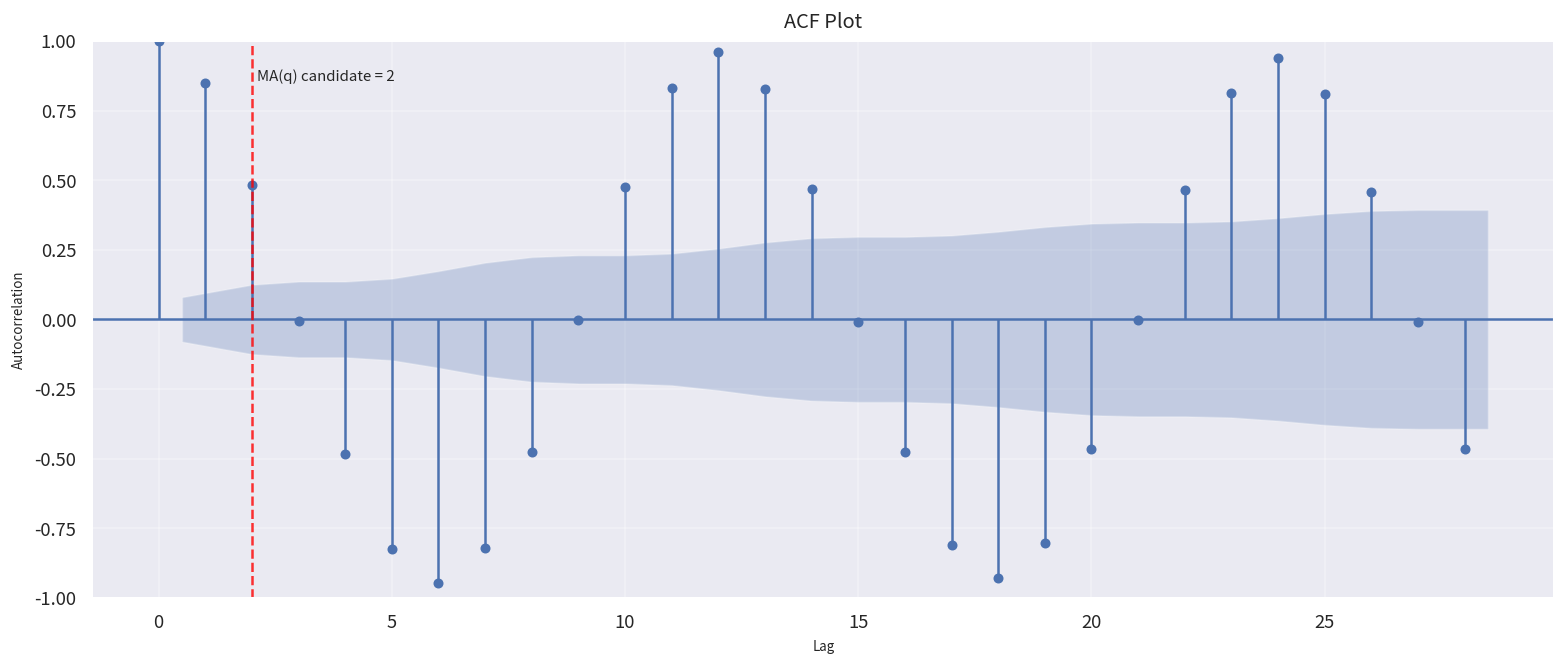

In [85]:
# 1) 그래프 초기화
width_px = 1600          # 그래프 가로 크기
height_px = 700          # 그래프 세로 크기
rows = 1                # 그래프 행 수
cols = 1                # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2-1) ACF Plot 그리기 -> ax 파라미터 필수
plot_acf(df2['평균기온(℃)'], ax=ax)

# 2-2) MA(q) 후보 시각화
ax.axvline(
    x=q_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color="red"
)

ax.text(
    q_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"MA(q) candidate = {q_candidate}",
    fontsize=9,
    verticalalignment="top"
)

# 3) 그래프 꾸미기
ax.set_title("ACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)   # 배경 격자 표시

# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료


> q 값은 2로 확인! 

#### 1.PACF 직접 계산하기

In [86]:
# 1) PACF 계산
pacf_vals = pacf(df2['평균기온(℃)'])
threshold = 2 / np.sqrt(len(df2['평균기온(℃)']))

# 2) 결과표 생성
df_pacf = DataFrame({
    "lag": np.arange(len(pacf_vals)),
    "pacf": pacf_vals,
})

# 3) 유의성 판단
df_pacf["abs_pacf"] = df_pacf["pacf"].abs()
df_pacf["significant"] = df_pacf["abs_pacf"] > threshold

# 4) 보기 좋게 정리
df_pacf["pacf"] = df_pacf["pacf"].round(3)
df_pacf["abs_pacf"] = df_pacf["abs_pacf"].round(3)
df_pacf["threshold"] = round(threshold, 3)

# 5) lag=0 제외
df_pacf_result = df_pacf.query("lag > 0").reset_index(drop=True)

# 6) 연속 유의 구간 계산
df_pacf_result["prev_significant"] = df_pacf_result["significant"].shift(1)

df_pacf_result["cut_candidate"] = (
    (df_pacf_result["prev_significant"] == True) &
    (df_pacf_result["significant"] == False)
)

df_pacf_result[["lag", "pacf", "significant", "cut_candidate"]]

df_pacf_result


,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,0.849,0.849,True,0.082,NaN,False
1,2,-0.855,0.855,True,0.082,True,False
2,3,-0.535,0.535,True,0.082,True,False
3,4,-0.352,0.352,True,0.082,True,False
4,5,-0.257,0.257,True,0.082,True,False
5,6,-0.279,0.279,True,0.082,True,False
6,7,-0.232,0.232,True,0.082,True,False
7,8,-0.082,0.082,True,0.082,True,False
8,9,0.192,0.192,True,0.082,True,False
9,10,0.273,0.273,True,0.082,True,False


In [87]:

p_candidate = (
    df_pacf_result
        .loc[df_pacf_result["cut_candidate"], "lag"]
        .min() - 1
)

p_candidate


np.int64(15)

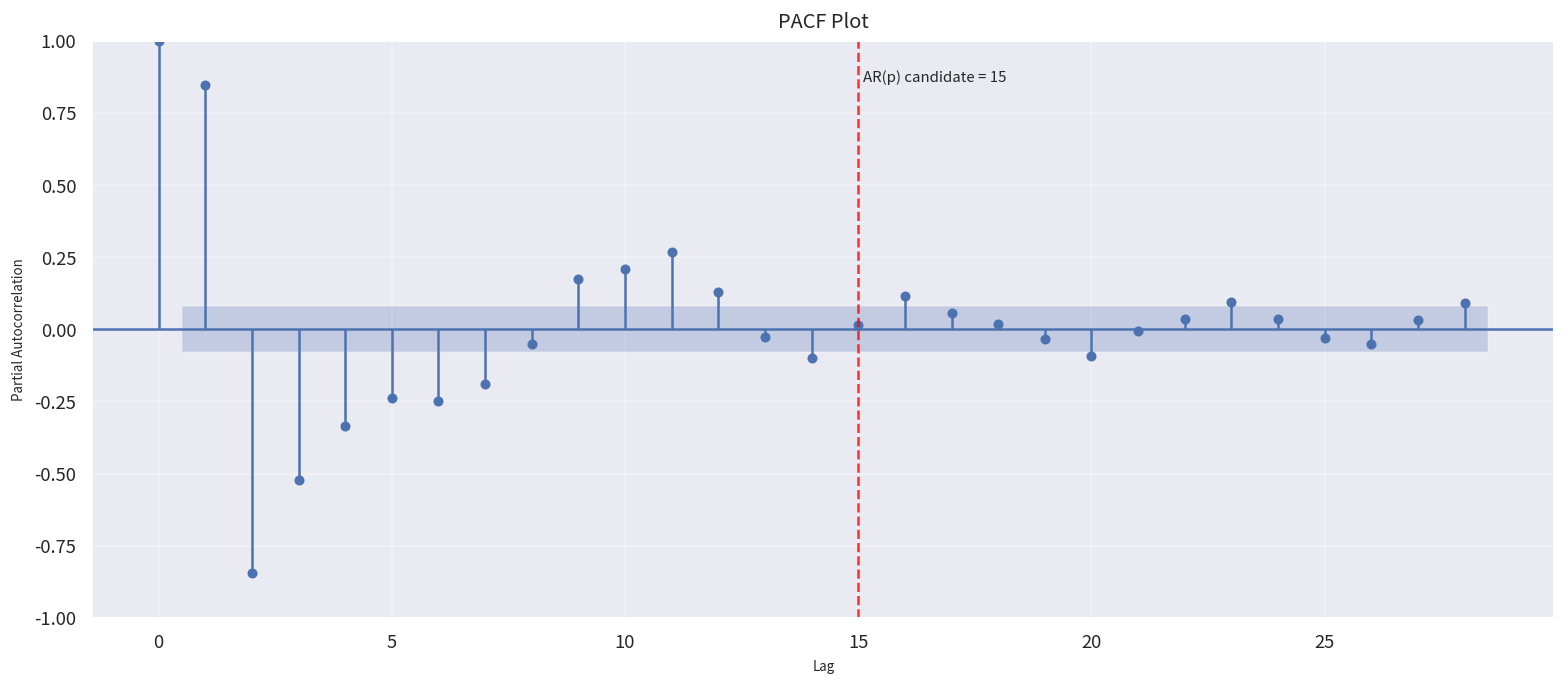

In [88]:
# 1) 그래프 초기화
width_px = 1600
height_px = 720
rows = 1
cols = 1

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2-1) PACF Plot 그리기
plot_pacf(df2['평균기온(℃)'], ax=ax)

# 2-2) AR(p) 후보 시각화
ax.axvline(
    x=p_candidate,
    linestyle="--",
    linewidth=1.5,
    alpha=0.8,
    color="red"
)

ax.text(
    p_candidate + 0.1,
    ax.get_ylim()[1] * 0.9,
    f"AR(p) candidate = {p_candidate}",
    fontsize=9,
    verticalalignment="top"
)

# 3) 그래프 꾸미기
ax.set_title("PACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Partial Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


> p 는 15

### ARIMA 분석 수행 
> 차분한 데이터가 아닌 원본 데이터에 돌려야함

In [ ]:
p = 15   #PACF
d = 0
q = 2   #ACF

results = []  # 결과 저장용

for x in range(0, p + 1):
    for y in range(0, d + 1),:
        for z in range(0, q + 1):
            try:
                # model = ARIMA(df2['평균기온(℃)'], order=(x, y, z))

                # 12개월 단위 계절성 추가
                model = ARIMA(
                    df2['평균기온(℃)'],
                    order=(x, y, z),
                    seasonal_order=(x, y, z, 12)
                )

                fit = model.fit()

                results.append({
                    'p': x,
                    'd': y,
                    'q': z,
                    'AIC': fit.aic,
                    'BIC': fit.bic
                })

            except Exception as e:
                # 수렴 실패 / 모델 오류는 건너뜀
                continue

df_results = DataFrame(results)

# 방법 1 - 합산 점수 고려
# df_results['AIC_rank'] = df_results['AIC'].rank()
# df_results['BIC_rank'] = df_results['BIC'].rank()
# df_results['rank_sum'] = df_results['AIC_rank'] + df_results['BIC_rank']
# best_model = df_results.sort_values('rank_sum').iloc[0]
# best_model

# 방법 2 - 보수적 기준: BIC 우선 + AIC 보조
best_model = df_results.sort_values(['BIC', 'AIC']).iloc[0]
best_model


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parame

#### 도출된 값으로 최종모형 만들기

In [ ]:
best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q'])
)

s_best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q']),
    6
)

final_model = ARIMA(
    df2['평균기온(℃)'],
    order=best_order,
    seasonal_order=s_best_order
)


#선택된 구조로 한번만, 깔끔하게 최종 학습!
final_fit = final_model.fit()

print(final_fit.summary())


                                    SARIMAX Results                                    
Dep. Variable:                         평균기온(℃)   No. Observations:                  602
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 6)   Log Likelihood               -1160.306
Date:                         Thu, 18 Dec 2025   AIC                           2332.612
Time:                                 17:18:52   BIC                           2359.013
Sample:                             07-01-1973   HQIC                          2342.888
                                  - 08-01-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5743      0.105    119.514      0.000      12.368      12.781
ar.L1          0.2219      0.098      2.272      0.023     

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 분석 결과 활용

In [ ]:
df2.head()

,평균기온(℃),rolling3,rolling6,rolling9
날짜,,,,
1973-07-01,26.816129,NaN,NaN,NaN
1973-08-01,25.883871,NaN,NaN,NaN
1973-09-01,20.323333,24.341111,NaN,NaN
1973-10-01,13.038710,19.748638,NaN,NaN
1973-11-01,4.723333,12.695125,NaN,NaN


In [ ]:

#모델이 학습 데이터에 대해 얼마나 잘 맞췄는지, 적합값을 확인하기 위한 준비 단계
df3 = df2.copy()
df3['pred'] = fit.fittedvalues  #훈련 데이터 구간에서 모델이 예측한 값들/ 모델이 과거 데이터를 보고 그떄의 값을 추청한 것
df3.head()

,평균기온(℃),rolling3,rolling6,rolling9,pred
날짜,,,,,
1973-07-01,26.816129,NaN,NaN,NaN,12.615773
1973-08-01,25.883871,NaN,NaN,NaN,23.277270
1973-09-01,20.323333,24.341111,NaN,NaN,21.639489
1973-10-01,13.038710,19.748638,NaN,NaN,15.450023
1973-11-01,4.723333,12.695125,NaN,NaN,8.279115


#### 2. 이후 1년간의 추가적인 예측값을 생성
- 월단위 데이터이므로 12개의 추가 데이터 생성

In [ ]:
fc = fit.forecast(12)
fc

2023-09-01    22.052762
2023-10-01    15.568257
2023-11-01     7.321049
2023-12-01     0.683442
2024-01-01    -1.340296
2024-02-01     1.724612
2024-03-01     7.706863
2024-04-01    13.737059
2024-05-01    19.496410
2024-06-01    23.463542
2024-07-01    26.301874
2024-08-01    26.570391
Freq: MS, Name: predicted_mean, dtype: float64

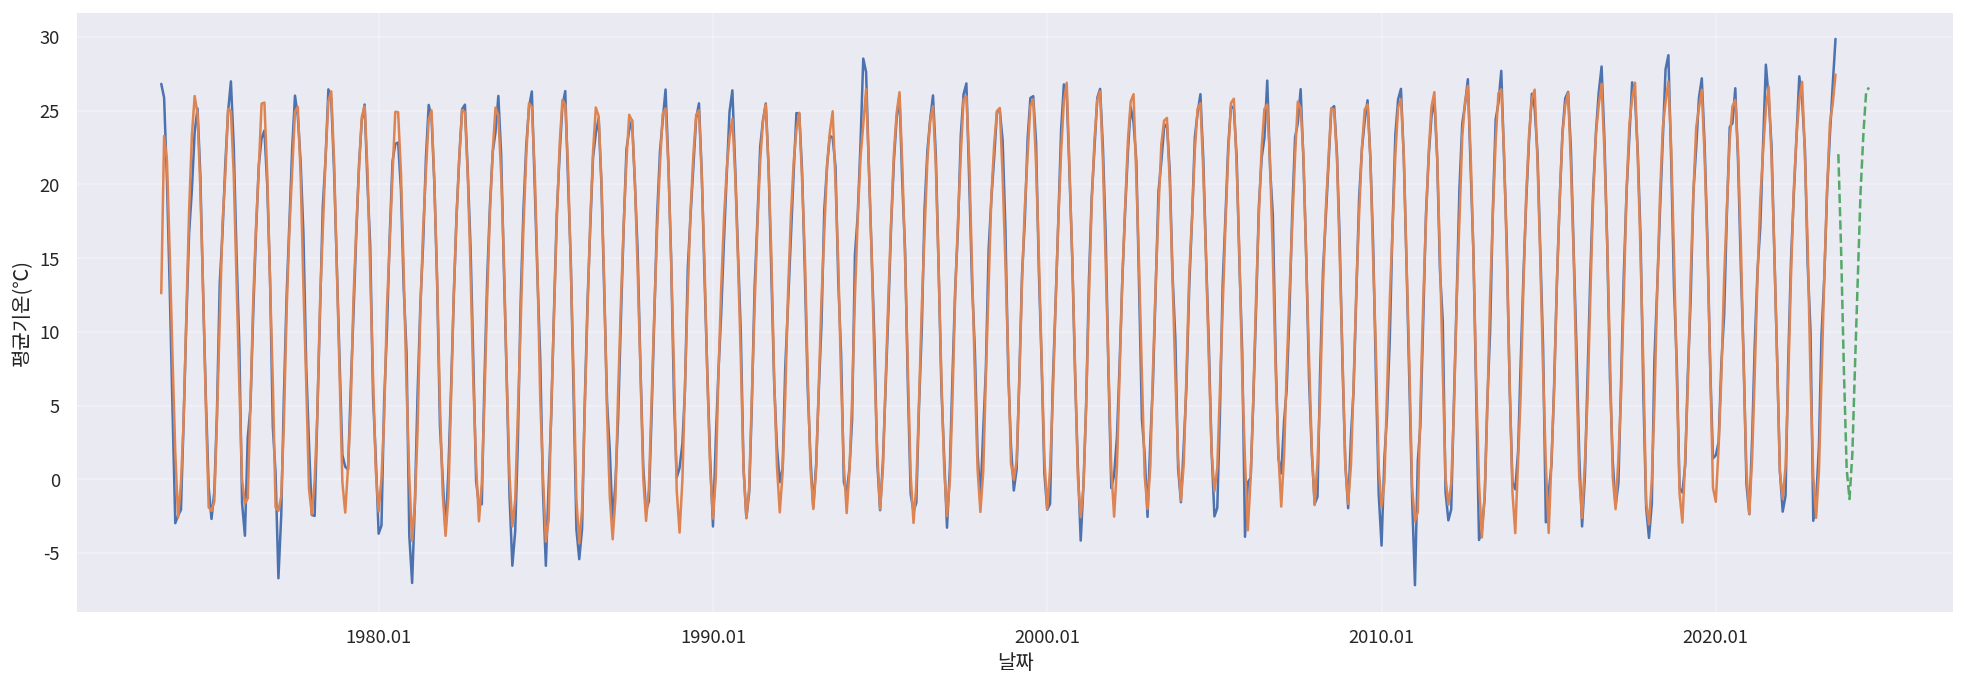

In [ ]:
# 1) 그래프 초기화
width_px = 2000           # 그래프 가로 크기
height_px = 720           # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
# 관측치
sb.lineplot(data=df3, x=df3.index, y="평균기온(℃)")

# 예측치
sb.lineplot(data=df3, x=df3.index, y="pred")

# 이후 예측
sb.lineplot(x=fc.index, y=fc.values, linestyle="--")

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)    # 배경 격자 표시

# 그래프의 축이 날짜 형식일 경우 출력 날짜 포맷 지정
monthyearFmt = dates.DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(monthyearFmt)

# 4) 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프 화면 출력
plt.close()                 # 그래프 작업 종료


### 분석 결과 해석
- 시계열 분석 결과 보고에서는 모형 구조 > 적합도 > 계수 해석 > 잔차 진단의 흐름이 가장 표준적

#### 결과보고함수

In [ ]:
from pandas import DataFrame

def arima_report(fit, data, threshold=0.05):
    """
    SARIMAXResults 객체(fit)와 원본 데이터(data)를 받아
    모형 적합도 표(cdf),
    계수 요약 표(rdf),
    모형 요약 문장(result_report),
    모형 판정 문장(model_report),
    계수별 해석 문장(variable_reports)를 반환한다.
    """

    # ----------------------------
    # 모형 적합도 요약
    # ----------------------------
    cdf = DataFrame({
        "Log Likelihood": [fit.llf],
        "AIC": [fit.aic],
        "BIC": [fit.bic],
        "HQIC": [fit.hqic],
        "관측치 수": [fit.nobs],
    })

    # ----------------------------
    # 계수 테이블 구성
    # ----------------------------
    params = fit.params
    bse = fit.bse
    zvals = params / bse
    pvals = fit.pvalues
    conf = fit.conf_int()

    rows = []
    for name in params.index:
        p = pvals[name]
        stars = (
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        rows.append({
            "변수": name,
            "계수": params[name],
            "표준오차": bse[name],
            "z": f"{zvals[name]:.3f}{stars}",
            "p-value": p,
            "CI_lower": conf.loc[name, 0],
            "CI_upper": conf.loc[name, 1],
        })

    rdf = DataFrame(rows)

    # ----------------------------
    # 모형 요약 문장
    # ----------------------------
    result_report = (
        f"Log Likelihood = {fit.llf:.3f}, "
        f"AIC = {fit.aic:.3f}, "
        f"BIC = {fit.bic:.3f}."
    )

    # ----------------------------
    # 모형 판정 문장
    # ----------------------------
    model_report = (
        f"ARIMA{fit.model.order}×{fit.model.seasonal_order} 모형을 적합한 결과, "
        f"AIC {fit.aic:.3f}, BIC {fit.bic:.3f}로 나타났으며 "
        f"잔차의 자기상관은 Ljung-Box 검정에서 유의하지 않았다."
    )

    # ----------------------------
    # 계수별 해석 문장
    # ----------------------------
    variable_reports = []
    for _, row in rdf.iterrows():
        variable_reports.append(
            f"{row['변수']} 계수는 {row['계수']:.3f}로 "
            f"통계적으로 {'유의하다' if row['p-value'] < threshold else '유의하지 않다'} "
            f"(p {'<' if row['p-value'] < threshold else '>'} {threshold})."
        )

    return cdf, rdf, result_report, model_report, variable_reports


In [ ]:
cdf ,rdf,r,m,v = arima_report(final_fit,df2)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,Log Likelihood,AIC,BIC,HQIC,관측치 수
0,-1160.305927,2332.611854,2359.013398,2342.887912,602


,변수,계수,표준오차,z,p-value,CI_lower,CI_upper
0,const,12.574325,0.105212,119.514***,0.000000e+00,12.368113,12.780536
1,ar.L1,0.221869,0.097641,2.272*,2.306948e-02,0.030495,0.413242
2,ma.L1,0.229258,0.095780,2.394*,1.668405e-02,0.041533,0.416983
3,ar.S.L6,-0.999998,0.000018,-56350.462***,0.000000e+00,-1.000033,-0.999963
4,ma.S.L6,0.992268,0.038377,25.855***,2.110406e-147,0.917050,1.067486
5,sigma2,2.583886,0.141352,18.280***,1.198750e-74,2.306841,2.860930


'Log Likelihood = -1160.306, AIC = 2332.612, BIC = 2359.013.'

'ARIMA(1, 0, 1)×(1, 0, 1, 6) 모형을 적합한 결과, AIC 2332.612, BIC 2359.013로 나타났으며 잔차의 자기상관은 Ljung-Box 검정에서 유의하지 않았다.'

['const 계수는 12.574로 통계적으로 유의하다 (p < 0.05).',
 'ar.L1 계수는 0.222로 통계적으로 유의하다 (p < 0.05).',
 'ma.L1 계수는 0.229로 통계적으로 유의하다 (p < 0.05).',
 'ar.S.L6 계수는 -1.000로 통계적으로 유의하다 (p < 0.05).',
 'ma.S.L6 계수는 0.992로 통계적으로 유의하다 (p < 0.05).',
 'sigma2 계수는 2.584로 통계적으로 유의하다 (p < 0.05).']